# Import

In [39]:
import sys
print(sys.executable)

/usr/bin/python3


In [40]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import matplotlib.patches as patches

# Run

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Pig length (in pixels): 146


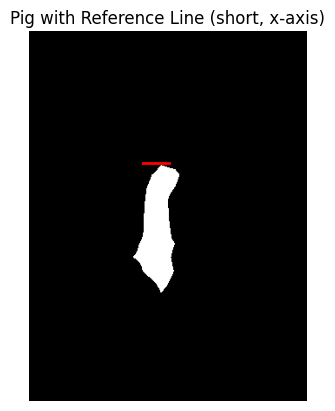

Pig length: 146.00 pixels ≈ 243.33 cm (using reference line)


In [41]:

model = models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True).eval()


input_image = Image.open('/content/URD-2_BlackPigProject/pig_segmentation/segment/blackpig1.jpg')
preprocess = transforms.Compose([
    transforms.Resize(320),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)['out'][0]
mask = output.argmax(0).byte().cpu().numpy()

binary_mask = (mask != 0).astype(np.uint8)

labeled, num_features = ndimage.label(binary_mask)

sizes = ndimage.sum(binary_mask, labeled, range(1, num_features + 1))
largest_label = (sizes.argmax() + 1)
pig_mask = (labeled == largest_label)

coords = np.column_stack(np.where(pig_mask))

min_row, min_col = coords.min(axis=0)
max_row, max_col = coords.max(axis=0)

pig_length_pixels = max(max_row - min_row, max_col - min_col)
print("Pig length (in pixels):", pig_length_pixels)

fig, ax = plt.subplots()
ax.imshow(pig_mask, cmap='gray')
#rect = patches.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row,
#linewidth=2, edgecolor='r', facecolor='none')
#ax.add_patch(rect)

center_row = (min_row + max_row) // 3
ref_length = 30
ref_start_col = min_col + (max_col - min_col - ref_length) // 2
ref_end_col = ref_start_col + ref_length
ax.plot([ref_start_col, ref_end_col], [center_row, center_row], color='red', linewidth=2, label=f'Reference Line ({ref_length} px)')

plt.title("Pig with Reference Line (short, x-axis)")
plt.axis('off')
plt.show()

reference_length_cm = 50
pixels_per_cm = ref_length / reference_length_cm
pig_length_pixels = max(max_row - min_row, max_col - min_col)
pig_length_cm = pig_length_pixels / pixels_per_cm
print(f"Pig length: {pig_length_pixels:.2f} pixels ≈ {pig_length_cm:.2f} cm (using reference line)")

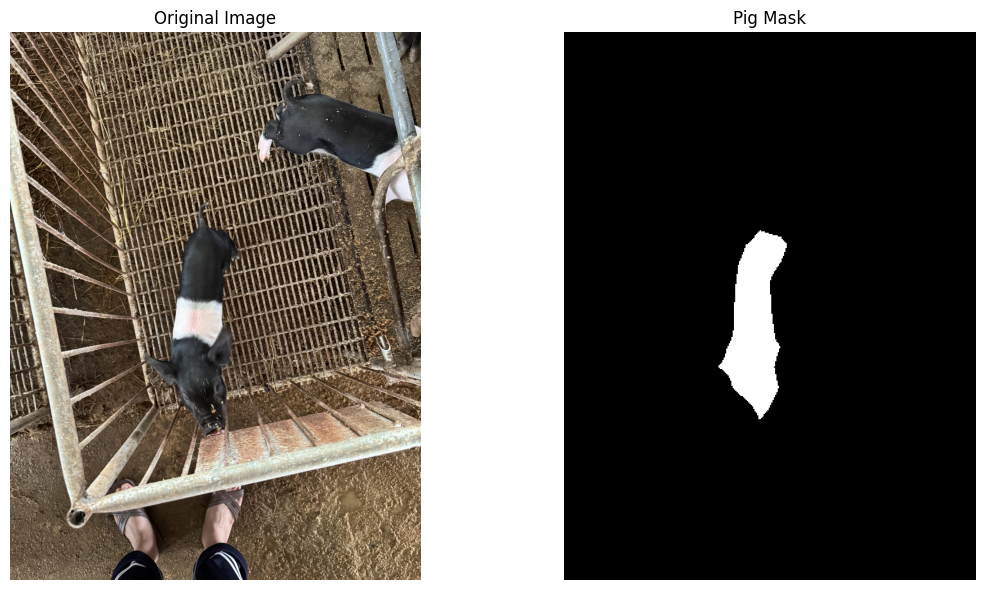

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(input_image)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(pig_mask, cmap='gray')
axes[1].set_title('Pig Mask')
axes[1].axis('off')
plt.tight_layout()
plt.show()

# Task
Fine-tune a pre-trained DeepLabV3 model to segment pig images, excluding their heads and tails, using a new dataset of augmented images and masks.

## Data preparation

### Subtask:
Load and organize the new dataset of original images and corresponding masks. Ensure the masks are in the correct format for training (e.g., pixel-wise labels).


In [43]:
import os
import glob

def load_image_mask_pairs(image_dir, mask_dir):
    """Loads image and mask file paths from specified directories."""
    image_paths = []
    for ext in ['*.png', '*.jpg', '*.jpeg']:
        image_paths.extend(glob.glob(os.path.join(image_dir, ext)))
    mask_paths = glob.glob(os.path.join(mask_dir, '*.png'))

    image_paths.sort()
    mask_paths.sort()

    if len(image_paths) != len(mask_paths):
        raise ValueError("Number of images and masks do not match!")

    return list(zip(image_paths, mask_paths))

image_directory = '/content/URD-2_BlackPigProject/pig_segmentation/segment/supervisely/augmented_dataset/img'
mask_directory = '/content/URD-2_BlackPigProject/pig_segmentation/segment/supervisely/augmented_dataset/masks'

try:
    dataset_pairs = load_image_mask_pairs(image_directory, mask_directory)
    print(f"Found {len(dataset_pairs)} image-mask pairs.")
    # You can inspect the first few pairs
    # print(dataset_pairs[:5])
except ValueError as e:
    print(f"Error loading dataset: {e}")

Found 35 image-mask pairs.


## Model Training

### Subtask:
Train the customized DeepLabV3 model on your prepared dataset.

In [44]:
import torch.nn as nn
import torch.optim as optim

# Define the loss function
# For binary segmentation (pig body vs. background), Binary Cross-Entropy is suitable
criterion = nn.BCEWithLogitsLoss() # Combines Sigmoid and BCELoss

# Define the optimizer
# Adam is a good general-purpose optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# You can also define other training parameters like learning rate scheduler, number of epochs, etc.
# For example, a learning rate scheduler can reduce the learning rate during training
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

print("Training setup complete: Loss function and optimizer defined.")

Training setup complete: Loss function and optimizer defined.


## Training Setup

### Subtask:
Define the loss function, optimizer, and training parameters.

## Data Preprocessing

### Subtask:
Apply necessary transformations to both the images and masks (e.g., resizing, normalization).

In [45]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class PigSegmentationDataset(Dataset):
    def __init__(self, image_mask_pairs, image_transform=None, mask_transform=None):
        self.image_mask_pairs = image_mask_pairs
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.image_mask_pairs[idx]
        image = Image.open(img_path).convert("RGB") # Ensure image is RGB
        mask = Image.open(mask_path).convert("L") # Convert mask to grayscale

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

# Define transformations
image_transforms = transforms.Compose([
    transforms.Resize((256, 256)), # Resize images to a fixed size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transforms = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST), # Resize masks using nearest neighbor interpolation
    transforms.ToTensor(),
])

# Create the dataset
segmentation_dataset = PigSegmentationDataset(dataset_pairs, image_transform=image_transforms, mask_transform=mask_transforms)

# Create a DataLoader (you can adjust batch_size and shuffle)
dataloader = DataLoader(segmentation_dataset, batch_size=4, shuffle=True)

print(f"Created dataset with {len(segmentation_dataset)} samples.")
# You can iterate through the dataloader to get batches of data
# for images, masks in dataloader:
#     print(images.shape, masks.shape)
#     break

Created dataset with 35 samples.


## Model Customization

### Subtask:
Modify the pretrained DeepLabV3 model to handle your specific segmentation task (excluding head and tail).

In [46]:
import torch
from torchvision import models

# Load the pre-trained DeepLabV3 model with a ResNet101 backbone
# Using weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1 for pretrained weights
model = models.segmentation.deeplabv3_resnet101(weights=models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1)

# Replace the classifier to output 1 class (pig body)
# The original model outputs 21 classes (VOC dataset)
model.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

# Modify the auxiliary classifier if present
# It has a different number of input channels than the main classifier
if model.aux_classifier is not None:
    model.aux_classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))


print("DeepLabV3 model customized for 1 output class.")

DeepLabV3 model customized for 1 output class.


## Visualize predictions

### Subtask:
Visualize the model's predictions on a few images from the training dataset to see how well it's segmenting the pigs. This will give us a visual understanding of the current performance.


**Reasoning**:
Iterate through the dataloader, get predictions from the model, and visualize the original images, ground truth masks, and predicted masks for a batch of data.



## Evaluate on a separate set

### Subtask:
If you have a separate validation or test set, evaluate the model's performance using appropriate segmentation metrics (e.g., IoU, Dice score). This provides a more objective measure of how well the model generalizes.


**Reasoning**:
Evaluate the model on a validation/test set to get objective performance metrics.



In [47]:
!pip install --upgrade torchmetrics

In [48]:
from sklearn.model_selection import train_test_split

# Split into training and testing sets (e.g., 80% train, 20% test)
train_pairs, test_pairs = train_test_split(dataset_pairs, test_size=0.2, random_state=42)

# Split the testing set into validation and testing sets (e.g., 50% validation, 50% test)
val_pairs, test_pairs = train_test_split(test_pairs, test_size=0.5, random_state=42)

print(f"Number of training samples: {len(train_pairs)}")
print(f"Number of validation samples: {len(val_pairs)}")
print(f"Number of testing samples: {len(test_pairs)}")

Number of training samples: 28
Number of validation samples: 3
Number of testing samples: 4


In [49]:
# Create the dataset instances
train_dataset = PigSegmentationDataset(train_pairs, image_transform=image_transforms, mask_transform=mask_transforms)
val_dataset = PigSegmentationDataset(val_pairs, image_transform=image_transforms, mask_transform=mask_transforms)
test_dataset = PigSegmentationDataset(test_pairs, image_transform=image_transforms, mask_transform=mask_transforms)

# Create the DataLoader instances
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

print(f"Created training dataset with {len(train_dataset)} samples and dataloader.")
print(f"Created validation dataset with {len(val_dataset)} samples and dataloader.")
print(f"Created testing dataset with {len(test_dataset)} samples and dataloader.")

Created training dataset with 28 samples and dataloader.
Created validation dataset with 3 samples and dataloader.
Created testing dataset with 4 samples and dataloader.


In [50]:
def train_fn(num_epochs, model, train_dataloader, criterion, optimizer_class, lr):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    optimizer = optimizer_class(model.parameters(), lr=lr)

    print(f"Starting training on device: {device} with lr={lr} and optimizer={optimizer_class.__name__}")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, masks in train_dataloader: # Use train_dataloader
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()

            outputs = model(images)['out']
            loss = criterion(outputs, masks.float())

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    print("Training finished!")

# Grid search loop
best_iou = -1
best_dice = -1
best_hyperparameters = None

for combination in itertools.product(*values):
    hyperparameters = dict(zip(keys, combination))
    print(f"Training with hyperparameters: {hyperparameters}")

    # Re-initialize the model for each training run
    model = models.segmentation.deeplabv3_resnet101(weights=models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1)
    model.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
    if model.aux_classifier is not None:
        model.aux_classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))


    # Train the model with the current hyperparameters using the train_dataloader
    train_fn(
        num_epochs=hyperparameters['num_epochs'],
        model=model,
        train_dataloader=train_dataloader, # Pass train_dataloader
        criterion=criterion,
        optimizer_class=hyperparameters['optimizer'],
        lr=hyperparameters['lr']
    )

    # Evaluate the model on the validation set using the val_dataloader
    model.eval()
    iou_metric.reset()
    total_dice = 0.0
    num_batches = 0
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    iou_metric.to(device)


    with torch.no_grad():
        for images, masks in val_dataloader: # Use val_dataloader for evaluation
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)['out']
            probabilities = torch.sigmoid(outputs)
            predicted_masks = (probabilities > 0.5).squeeze(1)

            masks = masks.squeeze(1).bool()

            batch_iou = iou_metric(predicted_masks.int(), masks.int())

            intersection = (predicted_masks & masks).sum()
            union = (predicted_masks | masks).sum()
            batch_dice = (2. * intersection) / (union + intersection) if (union + intersection) > 0 else 1.0

            total_dice += batch_dice.item()
            num_batches += 1

    average_iou = iou_metric.compute().item()
    average_dice = total_dice / num_batches

    print(f"Evaluation results - IoU: {average_iou:.4f}, Dice: {average_dice:.4f}")

    if average_iou > best_iou:
        best_iou = average_iou
        best_dice = average_dice
        best_hyperparameters = hyperparameters

print("\nGrid search finished.")
print("Best Hyperparameters:", best_hyperparameters)
print(f"Best IoU: {best_iou:.4f}")
print(f"Best Dice Score: {best_dice:.4f}")


Training with hyperparameters: {'lr': 0.001, 'num_epochs': 5, 'optimizer': <class 'torch.optim.adam.Adam'>}
Starting training on device: cuda with lr=0.001 and optimizer=Adam
Epoch [1/5], Loss: 0.4275
Epoch [2/5], Loss: 0.2465
Epoch [3/5], Loss: 0.1649
Epoch [4/5], Loss: 0.1174
Epoch [5/5], Loss: 0.0920
Training finished!
Evaluation results - IoU: 0.7587, Dice: 0.8628
Training with hyperparameters: {'lr': 0.001, 'num_epochs': 5, 'optimizer': <class 'torch.optim.sgd.SGD'>}
Starting training on device: cuda with lr=0.001 and optimizer=SGD
Epoch [1/5], Loss: 0.6660
Epoch [2/5], Loss: 0.6454
Epoch [3/5], Loss: 0.6239
Epoch [4/5], Loss: 0.5994
Epoch [5/5], Loss: 0.5849
Training finished!
Evaluation results - IoU: 0.1336, Dice: 0.2358
Training with hyperparameters: {'lr': 0.001, 'num_epochs': 10, 'optimizer': <class 'torch.optim.adam.Adam'>}
Starting training on device: cuda with lr=0.001 and optimizer=Adam
Epoch [1/10], Loss: 0.4767
Epoch [2/10], Loss: 0.2363
Epoch [3/10], Loss: 0.1723
Epoc

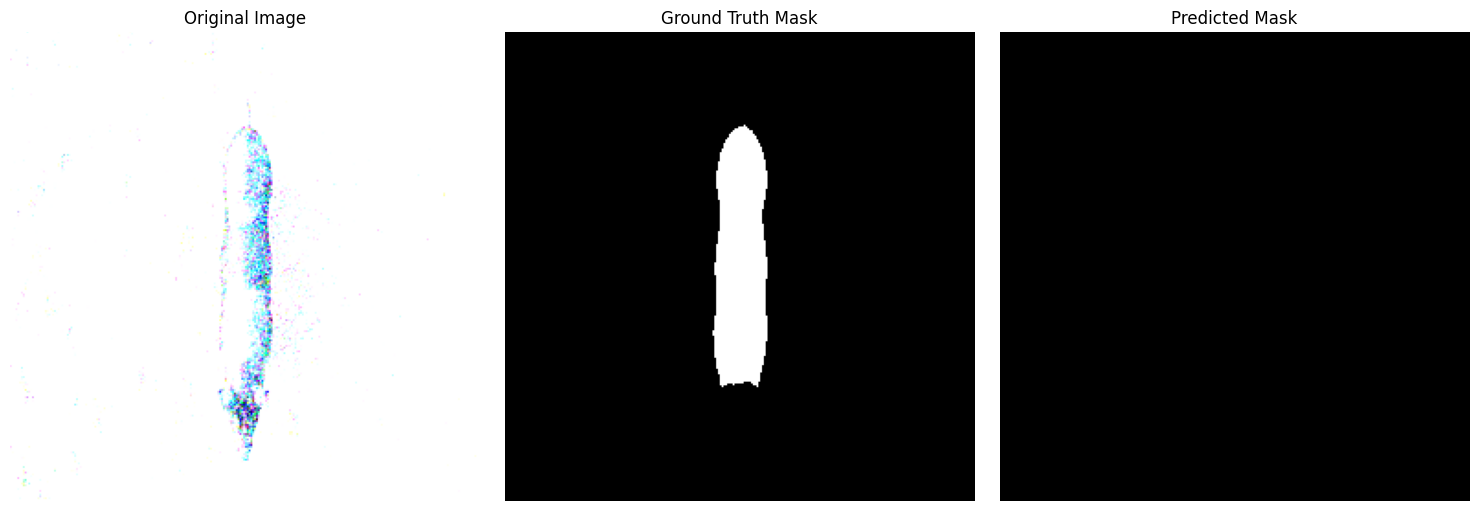

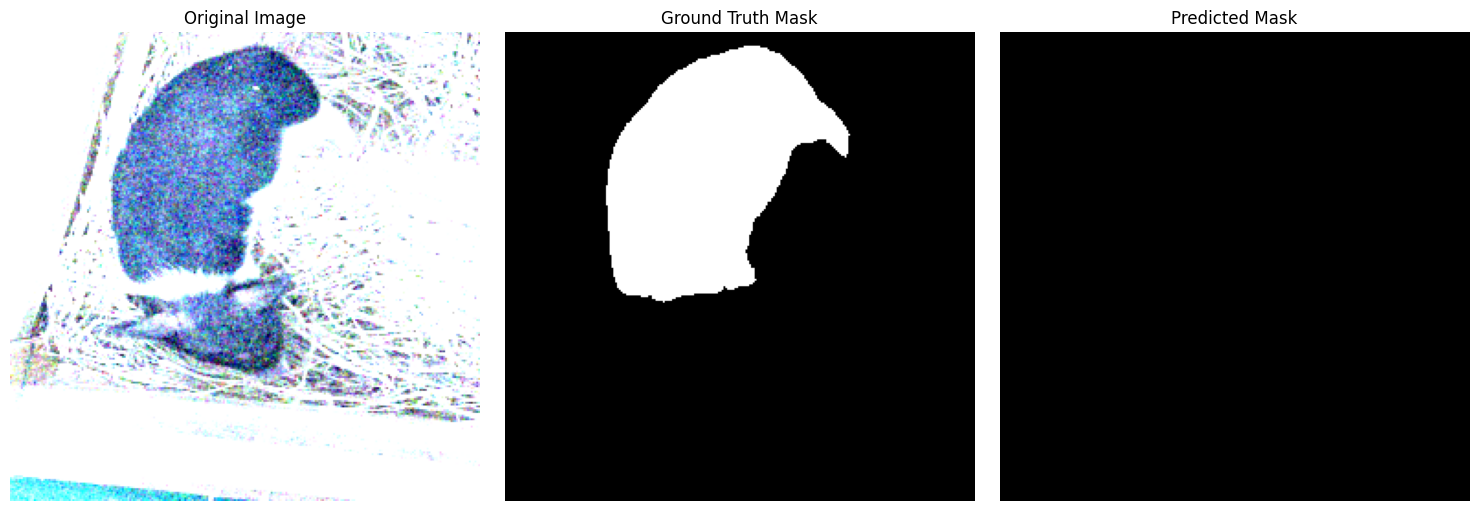

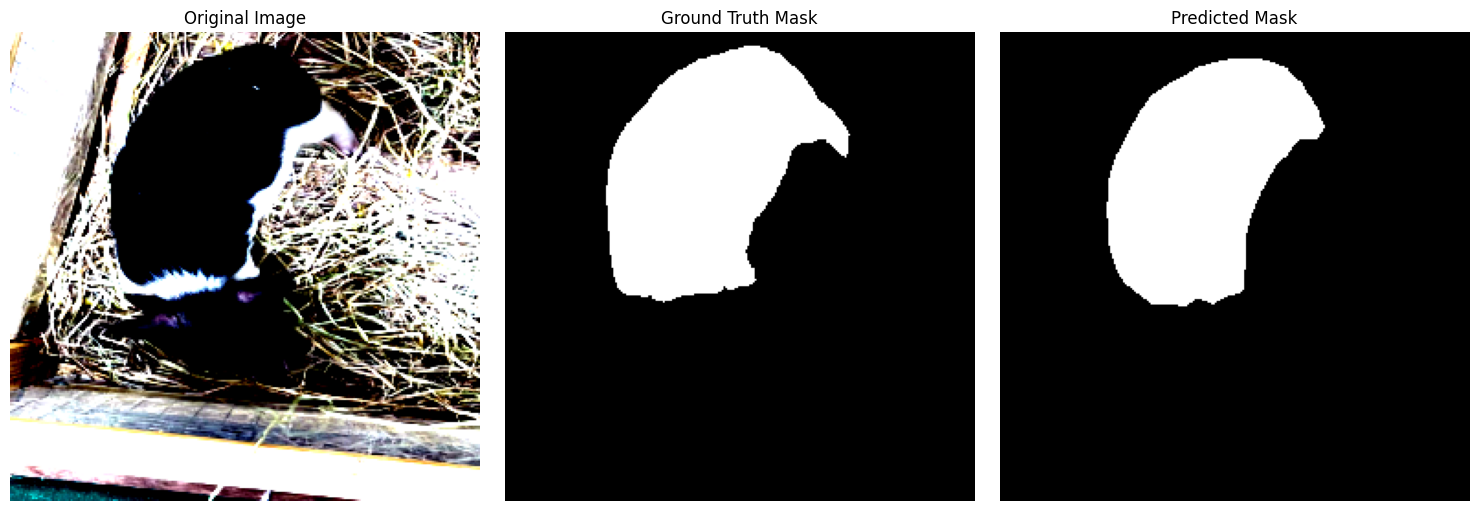

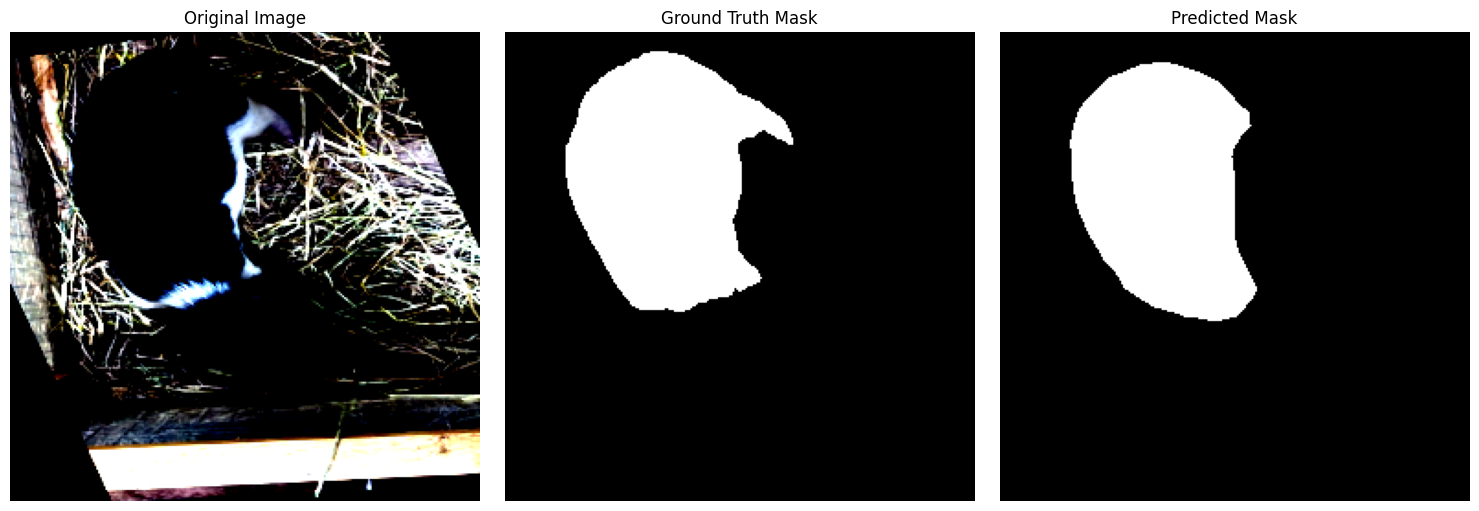

In [51]:
import matplotlib.pyplot as plt

# Get a batch of images and masks from the dataloader
images, masks = next(iter(dataloader))

# Move tensors to the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
images = images.to(device)
masks = masks.to(device)

# Set the model to evaluation mode and disable gradient calculation
model.eval()
with torch.no_grad():
    # Get model predictions
    outputs = model(images)['out']

# Apply sigmoid and threshold to get binary masks
probabilities = torch.sigmoid(outputs)
predicted_masks = (probabilities > 0.5).squeeze(1).cpu().numpy()

# Move original images and ground truth masks back to CPU for plotting
images = images.cpu().permute(0, 2, 3, 1).numpy()
masks = masks.cpu().squeeze(1).numpy()

# Visualize the results
for i in range(images.shape[0]):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    axes[0].imshow(images[i])
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Ground Truth Mask
    axes[1].imshow(masks[i], cmap='gray')
    axes[1].set_title('Ground Truth Mask')
    axes[1].axis('off')

    # Predicted Mask
    axes[2].imshow(predicted_masks[i], cmap='gray')
    axes[2].set_title('Predicted Mask')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()


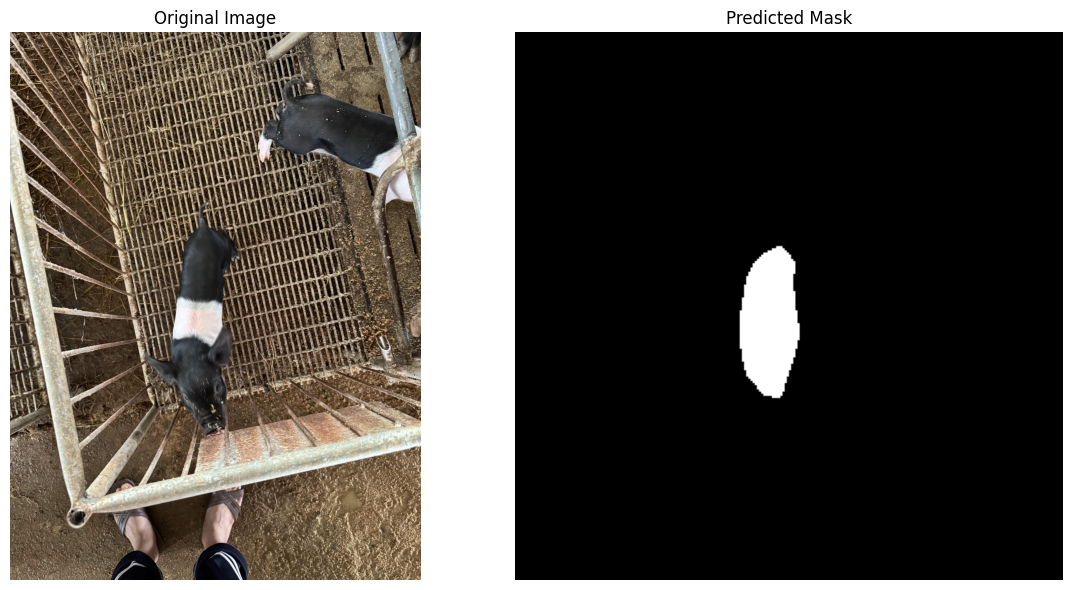

In [52]:
# Define the path to your input image
input_image_path = '/content/URD-2_BlackPigProject/pig_segmentation/segment/blackpig1.jpg' # Replace with the path to your image

# Load the input image
input_image = Image.open(input_image_path).convert("RGB")

# Apply the same transformations as used for the training data
# Ensure you use the correct transforms defined earlier (e.g., image_transforms)
input_tensor = image_transforms(input_image).unsqueeze(0) # Add a batch dimension

# Move the model and input tensor to the same device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
input_tensor = input_tensor.to(device)

# Set the model to evaluation mode and disable gradient calculation
model.eval()
with torch.no_grad():
    # Get model prediction
    output = model(input_tensor)['out']

# Apply sigmoid and threshold to get a binary mask
probabilities = torch.sigmoid(output)
predicted_mask = (probabilities > 0.5).squeeze(0).squeeze(0).cpu().numpy() # Remove batch and channel dimensions

# Visualize the original image and the predicted mask
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original Image
axes[0].imshow(input_image)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Predicted Mask
axes[1].imshow(predicted_mask, cmap='gray')
axes[1].set_title('Predicted Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()